# Mermaid Man and Barnacle Boy

*A Nitrous/IPA Gas-generator driven turbopump project*

Author: Elias Aoubala

Date: 01/12/2024

In [3]:
import numpy as np
import handcalcs.render
import pandas as pd
import matplotlib.pyplot as plt
import CoolProp.CoolProp as CP

## 1 - Background

This python notebook outlines all the calculations done by the author in the sizing of the turbine and gas generator stages of the turbopump

## 2 - Key Requirements

This section outlines all the key requirements for the turbine side of the gas generator, as specified by the IPA pump design requirements.

In [4]:
%%render

N = 30000 # rpm

P = 6.464 # kW


<IPython.core.display.Latex object>

Based on these requirements, we can start to size the turbine and gas generator accordingly.

## 3 - MR Selection

One of the first steps that needs to be conducted in the sizing of the two components is to decided what the mixture ratio of the gas generator is. This is mainly driven on material requirements, with a maximum combustion gas temperature being acceptable.

In this case,  we have opted for a maxium gas temperature of the gas generator to be around **800 K**.

We can assume the following chamber conditions for the gas generator

In [5]:
%%render sci_not

P_c = 5e5 # Pa

<IPython.core.display.Latex object>

Based on this, we can conduct a O/F sweep using NASA CEA to see how the combustion temperature varies as a function of combustion conditions. 

We will sweep an O/F from 1 to 5.

Text(0.5, 1.0, 'Variation of Combustion Temperature with MR')

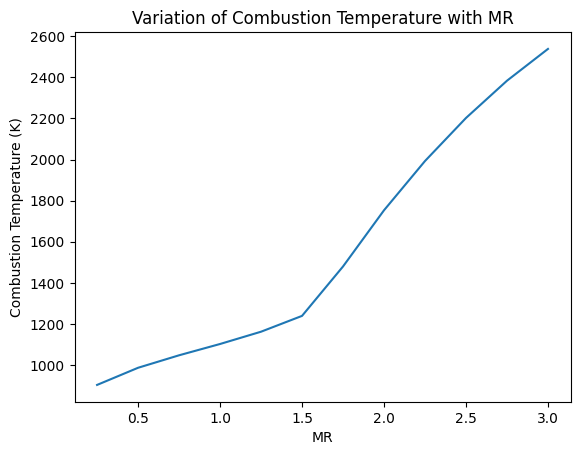

In [6]:
O_F_array = np.arange(0.25, 3 + 0.25, 0.25)

df = pd.read_csv("cea.txt").assign(o_f = O_F_array)

plt.plot(df["o_f"], df["t"])
plt.xlabel("MR")
plt.ylabel("Combustion Temperature (K)")
plt.title("Variation of Combustion Temperature with MR")

As can be seen, the combustion temperatures are significantly higher than we can plausibly accept for any reasonable MR. We must however consider the injector performance, as this normally has second order impacts on the combustion temperature.

c* is defined as the following:

$c^* = \frac{P_c A_t}{\dot{m}}$

We can derive the relationship between c* and the gas temperature to be as follows:

$c^* = \sqrt{\frac{T R}{\gamma} \left( \frac{\gamma + 1}{2} \right) ^{\frac{\gamma + 1}{\gamma -1 }})}$

We can assume thay any efficiency impact has negligible impact to the specific heat ratio of the specific gas constant of the resultant mixture, but only with the combustion temperature. Hence we can derive the following relationship for the $c^*$ efficiency with combustion temperature

$\eta_{c^*} = \frac{c^*_{act}}{c^*_{theo}} = \frac{\sqrt{T_{act}}}{\sqrt{T_{theo}}}$

Thus we can derive the actual combustion temperature as follows:

$T_{act} = T_{theo} \eta_{c^*}^2$

It should be noted that the assumption made that gas composition and specific heat ratio remain constant are unverified and can be gross, but it can be proximate for first pass sizing. The following c* efficiency has been assumed

In [7]:
%%render

eta_c = 0.85

<IPython.core.display.Latex object>

Based on this c* efficiency, we can now back calculate what our new combustion temperatures will be for the gas generators:

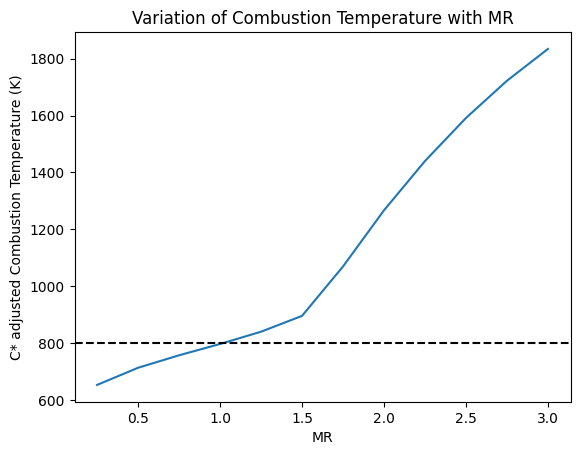

In [8]:
plt.plot(df["o_f"], df["t"] * eta_c**2)
plt.xlabel("MR")
plt.ylabel("C* adjusted Combustion Temperature (K)")
plt.title("Variation of Combustion Temperature with MR")
plt.axhline(800, linestyle="--", color="k")

Based on the above chart, we can base line an O/F of approximately 0.75 for the gas generator.

Now that we know our target set point, we can start to size our turbine wheel and figure out how big a gas generator we actually need to hit the performance metrics needed for the pump.

## 4 - Turbine Sizing

For the Turbine Sizing, we can assume Ideal gas effects for figuring out how much we will need to expand the gas.

The following equation for the specific energy release will be used:

$w = \eta_t \Delta h$

We can employ the ideal gas assumption to further expand this parameter to the following:

$w = \eta_t C_p (T_1 - T_{2s})$

We can further figure out what our isentropic expansion pressure would be accordingly using the following:

$\frac{P_2}{P_1} = \left(  \frac{T_{2s}}{T_1} \right) ^\frac{\gamma}{\gamma - 1}$

where $T_{2s}$ refers to the isentropic expansion temperature.

For the turbine stage efficiency, the following assumptions can be made:

In [9]:
%%render param

eta_t = 0.20 # Efficiency

<IPython.core.display.Latex object>

Based on this we can get an idea of what the required mass flow rates we would need for a given delta in temperature, from which we can see what the turbine expansion pressures needed to be

In [10]:
%%render sci_not
O_F = 0.75

eta_c = eta_c

T_inlet = df.loc[df["o_f"] == O_F]["t"].values[0] * eta_c**2 # K

gamma = df.loc[df["o_f"] == O_F]["gam"].values[0]

cp = df.loc[df["o_f"] == O_F]["cp"].values[0] # kJ/kg K

P_inlet = P_c # Pa


<IPython.core.display.Latex object>

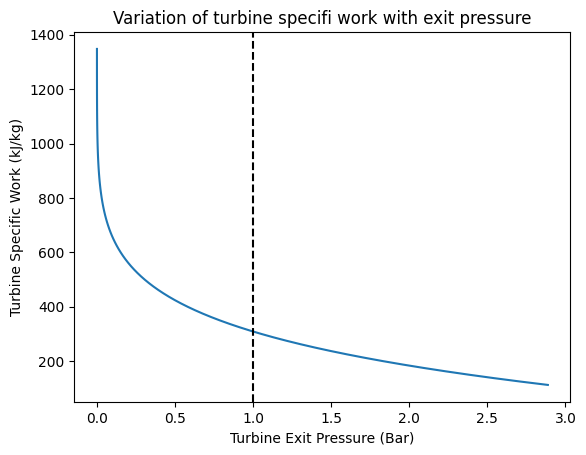

In [11]:
# We need to span different expansion temperatures to see what we


delta_T = np.linspace(50, 600, 100)

T_2s = T_inlet - delta_T

P_expand = P_inlet*(T_2s/T_inlet)**(gamma/(gamma - 1))

w = cp * eta_t * delta_T

plt.plot(P_expand/1e5, w)
plt.xlabel("Turbine Exit Pressure (Bar)")
plt.ylabel("Turbine Specific Work (kJ/kg)")
plt.title("Variation of turbine specifi work with exit pressure")
plt.axvline(1, linestyle="--", color="k")

As we decrease the expansion across the turbine, the turbine specific work drops at quite a significant pace. To quantify the impact this will have on the gas generator sizing interms of total mass flow, we can take our power requirement and calculate what the total required mass flow rate needed is.



In [12]:
%%render sci_not

P_req = P # kw

<IPython.core.display.Latex object>

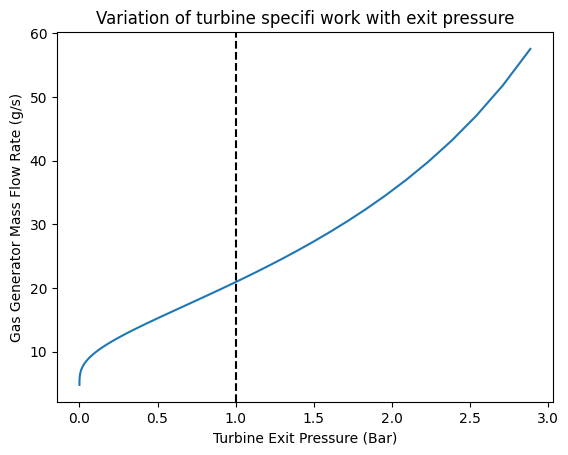

In [13]:
# We need to span different expansion temperatures to see what we

m_dot = P / w

plt.plot(P_expand / 1e5, m_dot*1e3)
plt.xlabel("Turbine Exit Pressure (Bar)")
plt.ylabel("Gas Generator Mass Flow Rate (g/s)")
plt.title("Variation of turbine specifi work with exit pressure")
plt.axvline(1, linestyle="--", color="k")

Based on the graph, we can see that as we want to expand further from the ambient enviroment, the requirements for the gas generator increase approximately linearly. What we can suggest is we select a turbine exit pressure with a comfortable margin to allow for downstream optimisation of the gas generator.

In this case, we will aim for an exit turbine pressure of 2.5 Bar, to allow for a reasonably nozzle to be implemented.

In [14]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

idx = find_nearest(P_expand, 2.5e5)

Thus the turbine and gas generator requirements are now the following:

In [16]:
%%render params sci_not

m_dot_gg = m_dot[idx] # kg/s

T_inlet = T_inlet # K

T_exit_s = T_2s[idx] # K

T_exit_a = T_inlet - eta_t*(T_inlet - T_exit_s) # K

P_inlet = P_inlet # Pa

P_exit = P_expand[idx] # Pa

P_act = P_req/eta_t

<IPython.core.display.Latex object>

## 5 - Gas-generator Design

We can now continue onto the gas generator design, focusing primarily on the strategy for our injection and ignition.

The high-level specifications of the system are the following:

In [250]:
%%render sci_not

m_dot_tot = m_dot_gg # kg/s

P_inlet = P_inlet # Pa

O_F = O_F

Oxidiser = "Nitrous"

Fuel = "IPA"

<IPython.core.display.Latex object>

### 5.1 - Injector Design

We can start of with out injector design for the gas generator.

#### 5.1.1 - Fuel Injection

For fuel injection, we will target the following injection parameters:

In [251]:
%%render

fuel_stiffness = 100 # \%

rho_f = 786 # kg/m**3

Cd_f = 0.6

<IPython.core.display.Latex object>

Based on these criterion, we can derive the following parameters for the injection

In [252]:
%%render sci_not

P_f_inlet = P_c + P_c*fuel_stiffness/100 # Pa

m_f = m_dot_gg/(O_F + 1) # kg/s

A_f = m_f / (Cd_f * (2 * rho_f * (P_f_inlet - P_c))**(1/2)) # m**2

<IPython.core.display.Latex object>

#### 5.1.2 - Oxidiser Injection

For Oxidiser injection, we will target the following injection parameters:

In [253]:
%%render

P_o_inlet = 40e5

dp_o = P_o_inlet - P_c

oxidiser_stiffness = dp_o/P_c *1e2 # \%

rho_o = CP.PropsSI("D", "P", P_o_inlet, "Q", 0, "NitrousOxide")

Cd_o = 0.5

<IPython.core.display.Latex object>

Based on these criterion, we can derive the following parameters for the injection

In [254]:
%%render sci_not

m_o = O_F*m_dot_gg/(O_F + 1)

A_o = m_o / (Cd_o * (2 * rho_o * (P_o_inlet - P_c))**(1/2)) # m**2

<IPython.core.display.Latex object>

We need to now figure out our injection geometries and patterns accordingly, including our implementation of film cooling and the igniter mass flow

#### 5.2 - Injection Pattern

Given the extremely small flow rates, we will design our injector to be a coaxial injector.

We will aim for a fuel centered injector, as we can manipulate the areas to meet the COTS requirements.

The Hyperdermic needle we want are the following:

https://www.adhesivedispensing.co.uk/stainless-steel-19g-tube-110mm-od-sst19-4117-p.asp


OD: 1.1 mm

ID: 0.7 mm

In [277]:
%%render

N = 4

A_f_element = A_f/N # m**2

D_f = (A_f_element/np.pi)**(1/2) * 2 * 1e3 # mm



<IPython.core.display.Latex object>

This is approximately hitting our requirement for the ID of the orifice.

In [284]:
%%render sci_not

D_ext = 1.1e-3 # m

A_o_anulus =  A_o/N

A_inner = np.pi * (D_ext/2)**2

A_outer = A_o_anulus + A_inner

D_outer = (A_outer/np.pi)**(1/2) * 2 * 1e3 # mm

<IPython.core.display.Latex object>

We can approximate this to be 1.2 mm.

Thus the overall specifications for the injector are the following:

- Fuel Centered Coaxial Injector

- 4 Elements

- 1.1 mm OD 0.7 mm ID hypodermic needles

## 6 - Turbine Design

As we have done the basics for the turbine and gas generator specifications, we can now do some simple mean line design for the turbine.

The target for this design is an impulse design, with a degree of reaction of zero (all expansion occurs in the stator stage of the turbine).

We need to now do the mean line design of the turbine.

### 6.1 - Mean-Line Design of the Turbine

We know that based on Euler's Turbomachinery equation that the power produced by a turbine stage si defined as the following:

$P = \dot{m}(U_2 V_{\theta 2} - U_1 V_{\theta 1})$

where $\dot{m}$ refers to the mass flow rate through the turbine, $U$ refers to the blade velocities and $V$ refers to the radial velocity component of the gas.

We already have defined our mass flow rate, so now we need to define our velocity "triangles" for the turbine stages.

Firstly, as we are using a cantilevered turbine, we can define the blade velocity as a function of the RPM of the turbine and radial positions of the inlet and exit conditions of the turbine as follows:

$P = \dot{m} N (r_2 V_{\theta 2} - r_1 V_{\theta 1})$

We already know our power requirement, gas generator mass flow and rotational speed for the turbine, this we can dervive the value of that internal parameter accordingly.

In [30]:
%%render sci_not

P = P_act # kW

m_dot_gg = m_dot_gg # kg/s

N = N # rpm

rot_f = (P*1e3)/(m_dot_gg*(N*2*np.pi/60)) # m**2/s

<IPython.core.display.Latex object>

Now that we have this parameter and that it is fixed, we can do a brief study to investigate the impact of varying inlet and exit velocities so we can better define our required operating criteria.

There are three key parameters we can realistically play with:
- Radii for the turbine blades
- Inlet and Exit Angles of the Turbine Blade
- Inlet Velocity of the Turbine Blades (from the Stator)

Key Assumption that will be used here is the turbine blade geometry will be symmetric, implying the inlet and exit relative angles are equal ($\beta_1 = \beta_2$)

## Impact of Blade Metal Angles on 